In [0]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, data
import matplotlib.pyplot as plt

ctx = mx.gpu()

##Getting our data

In [0]:
def transform(data, label):
    return nd.moveaxis(data.astype('float32'), 2, 0)/255.0, label.astype('float32')

train_cifar = data.vision.datasets.CIFAR10(train = True, transform = transform)
test_cifar = data.vision.datasets.CIFAR10(train = False, transform = transform)

In [0]:
image, label = train_cifar[456]
image.shape, label.shape

((3, 32, 32), ())

In [0]:
batch_size = 128
train_data = data.DataLoader(train_cifar, batch_size, True)
test_data = data.DataLoader(test_cifar, batch_size, False)

##Building the model

In [0]:
model = nn.Sequential()
model.add(nn.Conv2D(channels = 16, kernel_size = (5, 5)))
model.add(nn.BatchNorm())
model.add(nn.Activation('relu'))
model.add(nn.MaxPool2D(pool_size = 2, strides = 1))

model.add(nn.Conv2D(channels = 32, kernel_size = (5, 5)))
model.add(nn.BatchNorm())
model.add(nn.Activation('relu'))
model.add(nn.MaxPool2D(pool_size = 2, strides = 1))

model.add(nn.Conv2D(channels = 64, kernel_size = (5, 5)))
model.add(nn.BatchNorm())
model.add(nn.Activation('relu'))
model.add(nn.MaxPool2D(pool_size = 2, strides = 1))

model.add(nn.Flatten())

model.add(nn.Dense(512))
model.add(nn.BatchNorm())
model.add(nn.Activation('relu'))
model.add(nn.Dropout(0.5))

model.add(nn.Dense(256))
model.add(nn.BatchNorm())
model.add(nn.Activation('relu'))
model.add(nn.Dropout(0.5))

model.add(nn.Dense(10))

model.initialize(mx.init.Xavier(), ctx)

##Printing model definition

In [0]:
model

Sequential(
  (0): Conv2D(None -> 16, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (2): Activation(relu)
  (3): MaxPool2D(size=(2, 2), stride=(1, 1), padding=(0, 0), ceil_mode=False)
  (4): Conv2D(None -> 32, kernel_size=(5, 5), stride=(1, 1))
  (5): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (6): Activation(relu)
  (7): MaxPool2D(size=(2, 2), stride=(1, 1), padding=(0, 0), ceil_mode=False)
  (8): Conv2D(None -> 64, kernel_size=(5, 5), stride=(1, 1))
  (9): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (10): Activation(relu)
  (11): MaxPool2D(size=(2, 2), stride=(1, 1), padding=(0, 0), ceil_mode=False)
  (12): Flatten
  (13): Dense(None -> 512, linear)
  (14): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (15): A

##Printing model computation summary 

In [0]:
model.summary(image.expand_dims(0).as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                              (1, 3, 32, 32)               0
            Conv2D-1                             (1, 16, 28, 28)            1216
         BatchNorm-2                             (1, 16, 28, 28)              64
        Activation-3                             (1, 16, 28, 28)               0
         MaxPool2D-4                             (1, 16, 27, 27)               0
            Conv2D-5                             (1, 32, 23, 23)           12832
         BatchNorm-6                             (1, 32, 23, 23)             128
        Activation-7                             (1, 32, 23, 23)               0
         MaxPool2D-8                             (1, 32, 22, 22)               0
            Conv2D-9                             (1, 64, 18, 18)           51264
        BatchNorm-10        

##Defining objective function

In [0]:
objective = gluon.loss.SoftmaxCrossEntropyLoss()

##Defining optimizer

In [0]:
optimizer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.001})

##Defining our accuracy function

In [0]:
metric = mx.metric.Accuracy()

##Training the  model

In [0]:
epochs = 10
losses = []
accs = []

for epoch in range(epochs):
    cumulative_loss = 0
    metric.reset()
    for batches, (features, labels) in enumerate(train_data, 1):
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx)
        with autograd.record():
            output = model(features)
            loss = objective(output, labels)
        loss.backward()
        optimizer.step(batch_size)
        cumulative_loss += loss.mean()
        metric.update(labels, output)
    acc = metric.get()[1]
    losses.append(cumulative_loss.asscalar())
    accs.append(acc)
    print(f'Epoch: {epoch} | Loss: {cumulative_loss.asscalar()/(batches):.5f} | Accuracy: {acc:.5f}')

Epoch: 0 | Loss: 1.55657 | Accuracy: 0.44776
Epoch: 1 | Loss: 1.11562 | Accuracy: 0.60742
Epoch: 2 | Loss: 0.97464 | Accuracy: 0.65814
Epoch: 3 | Loss: 0.88400 | Accuracy: 0.69018
Epoch: 4 | Loss: 0.80990 | Accuracy: 0.71650
Epoch: 5 | Loss: 0.74595 | Accuracy: 0.73598
Epoch: 6 | Loss: 0.70015 | Accuracy: 0.75522
Epoch: 7 | Loss: 0.64134 | Accuracy: 0.77454
Epoch: 8 | Loss: 0.59926 | Accuracy: 0.78832
Epoch: 9 | Loss: 0.55550 | Accuracy: 0.80462


In [0]:
metric.reset()
for features, labels in test_data:
    features = features.as_in_context(mx.gpu())
    labels = labels.as_in_context(mx.gpu())
    predictions = model(features)
    metric.update(labels, predictions)
print(f'Test Accuracy: {metric.get()[1]:.5f}')

Test Accuracy: 0.70580


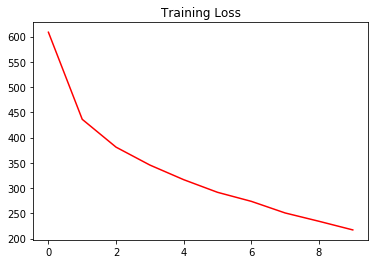

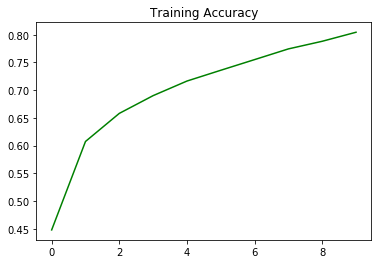

In [0]:
plt.plot(losses, c = 'r')
plt.title('Training Loss')
plt.show()

plt.plot(accs, c = 'g')
plt.title('Training Accuracy')
plt.show()